In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import os
import re
import os
import pandas as pd
from pathlib import Path
import pytz
from datetime import datetime
import numpy as np

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np


# ------------------------------------------------------------
# Your weighted mean function (with N included)
# ------------------------------------------------------------
def analyze_single_weighted_mean(list_of_dfs, value_col, uncertainty_col):

    values = []
    uncertainties = []

    for df in list_of_dfs:
        values.append(df[value_col].to_numpy())
        uncertainties.append(df[uncertainty_col].to_numpy())

    x = np.concatenate(values)
    sigma = np.concatenate(uncertainties)

    w = 1.0 / sigma**2
    weighted_mean = np.sum(w * x) / np.sum(w)
    unscaled_uncertainty = np.sqrt(1.0 / np.sum(w))

    chi2 = np.sum(((x - weighted_mean)**2) / sigma**2)
    N = len(x)
    reduced_chi2 = chi2 / (N - 1)

    return N, reduced_chi2, weighted_mean, unscaled_uncertainty


# ------------------------------------------------------------
# Parse a range string like "12,13-15" → [12,13,14,15]
# ------------------------------------------------------------
def parse_range_string(s):
    nums = []
    parts = s.split(",")

    for p in parts:
        if "-" in p:
            a, b = p.split("-")
            nums.extend(range(int(a), int(b) + 1))
        else:
            nums.append(int(p))

    return nums


# ------------------------------------------------------------
# Convert integer ID → filename like "0015.0049.csv"
# ------------------------------------------------------------
def index_to_filename(base_prefix, idx):
    return f"{base_prefix}.{idx:04d}.csv"


# ------------------------------------------------------------
# Main function
# ------------------------------------------------------------
def process_by_index_ranges(folder, base_prefix, range_strings):

    folder = Path(folder)
    results = []

    for range_str in range_strings:

        # Parse the string into integer IDs
        indices = parse_range_string(range_str)

        # Build list of existing dataframes
        dfs = []
        existing_paths = []

        for idx in indices:
            filename = index_to_filename(base_prefix, idx)
            path = folder / filename

            if path.exists():
                df = pd.read_csv(path)
                dfs.append(df)
                existing_paths.append(str(path))

        # If no files exist for this range, skip
        if len(dfs) == 0:
            results.append({
                "range": range_str,
                "existing_files": [],
                "N": 0,
                "reduced_chi2": None,
                "weighted_mean": None,
                "unscaled_uncertainty": None,
            })
            continue

        # Run the weighted mean analysis
        N, reduced_chi2, weighted_mean, unscaled_unc = analyze_single_weighted_mean(
            dfs,
            value_col="omega_NE",
            uncertainty_col="uncertainty_omega_NE",
        )

        results.append({
            "range": range_str,
            "existing_files": existing_paths,
            "N": N,
            "reduced_chi2": reduced_chi2,
            "weighted_mean": weighted_mean,
            "unscaled_uncertainty": unscaled_unc,
        })

    df_results = pd.DataFrame(results)
    return df_results


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path


def analyze_files_individually(folder):
    folder = Path(folder)

    # Sort lexicographically
    file_list = sorted([f for f in folder.iterdir() if f.is_file()])

    results = []

    for path in file_list:
        df = pd.read_csv(path)

        # Extract columns
        x = df["omega_NE"].to_numpy()
        sigma = df["uncertainty_omega_NE"].to_numpy()

        # Weights
        w = 1.0 / sigma**2

        # Weighted mean
        weighted_mean = np.sum(w * x) / np.sum(w)

        # Unscaled uncertainty of mean
        unscaled_unc = np.sqrt(1.0 / np.sum(w))

        # Reduced chi2
        chi2 = np.sum(((x - weighted_mean)**2) / sigma**2)
        N = len(x)
        reduced_chi2 = chi2 / (N - 1)

        # Scaled uncertainty
        scaled_unc = np.sqrt(reduced_chi2) * unscaled_unc

        results.append({
            "path": str(path),
            "N": N,
            "weighted_mean": weighted_mean,
            "unscaled_uncertainty": unscaled_unc,
            "reduced_chi2": reduced_chi2,
            "scaled_uncertainty": scaled_unc,
        })

    df_result = pd.DataFrame(results)
    return df_result


In [4]:
df_result = analyze_files_individually(r"C:\ACME_analysis\long_data_sets")
print(df_result)

C:\Users\ACME\AppData\Local\Temp\ipykernel_10940\1629022271.py:33: RuntimeWarning: invalid value encountered in scalar divide
  reduced_chi2 = chi2 / (N - 1)


                                             path    N  weighted_mean  \
0   C:\ACME_analysis\long_data_sets\0015.0007.csv   16      -0.001054   
1   C:\ACME_analysis\long_data_sets\0015.0031.csv    8       0.001249   
2   C:\ACME_analysis\long_data_sets\0015.0124.csv    8      -0.005671   
3   C:\ACME_analysis\long_data_sets\0015.0127.csv    2      -0.001785   
4   C:\ACME_analysis\long_data_sets\0015.0130.csv    8       0.011162   
5   C:\ACME_analysis\long_data_sets\0015.0132.csv    8      -0.001115   
6   C:\ACME_analysis\long_data_sets\0015.0134.csv    4      -0.001745   
7   C:\ACME_analysis\long_data_sets\0015.0195.csv    8      -0.000894   
8   C:\ACME_analysis\long_data_sets\0015.0220.csv   16       0.001589   
9   C:\ACME_analysis\long_data_sets\0015.0226.csv    8      -0.001683   
10  C:\ACME_analysis\long_data_sets\0015.0272.csv    8      -0.000300   
11  C:\ACME_analysis\long_data_sets\0015.0274.csv    8      -0.001486   
12  C:\ACME_analysis\long_data_sets\0015.0431.csv  

In [5]:
df_result

,path,N,weighted_mean,unscaled_uncertainty,reduced_chi2,scaled_uncertainty
0,C:\ACME_analysis\long_data_sets\0015.0007.csv,16,-0.001054,0.000477,1.283462,0.000541
1,C:\ACME_analysis\long_data_sets\0015.0031.csv,8,0.001249,0.000612,2.941380,0.001050
2,C:\ACME_analysis\long_data_sets\0015.0124.csv,8,-0.005671,0.000698,2.258672,0.001049
3,C:\ACME_analysis\long_data_sets\0015.0127.csv,2,-0.001785,0.000973,0.194715,0.000429
4,C:\ACME_analysis\long_data_sets\0015.0130.csv,8,0.011162,0.001120,6.773780,0.002914
5,C:\ACME_analysis\long_data_sets\0015.0132.csv,8,-0.001115,0.000646,0.920202,0.000620
6,C:\ACME_analysis\long_data_sets\0015.0134.csv,4,-0.001745,0.001898,1.658909,0.002444
7,C:\ACME_analysis\long_data_sets\0015.0195.csv,8,-0.000894,0.000623,1.808947,0.000838
8,C:\ACME_analysis\long_data_sets\0015.0220.csv,16,0.001589,0.003027,1.600996,0.003830
9,C:\ACME_analysis\long_data_sets\0015.0226.csv,8,-0.001683,0.000627,1.399249,0.000741


(-3000.0, 2500.0)

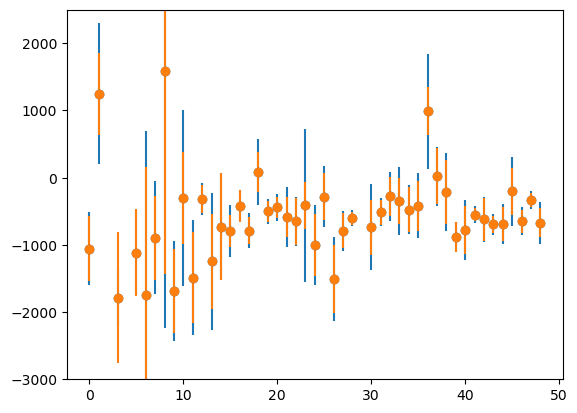

In [6]:
plt.errorbar(x = df_result.index, y = 1000000 * df_result['weighted_mean'], yerr = 1000000 * df_result['unscaled_uncertainty'] * np.sqrt(df_result["reduced_chi2"]), fmt='o')
plt.errorbar(x = df_result.index, y = 1000000 * df_result['weighted_mean'], yerr = 1000000 * df_result['unscaled_uncertainty'] , fmt='o')
plt.ylim(-3000,2500)

In [9]:
# weighted mean of weighted means
x = df_result['weighted_mean']
sigma = df_result['unscaled_uncertainty'] * np.sqrt(df_result["reduced_chi2"])
w = 1.0 / sigma**2
weighted_mean = np.sum(w * x) / np.sum(w)
unscaled_uncertainty = np.sqrt(1.0 / np.sum(w))
print(weighted_mean, unscaled_uncertainty)

-0.000574415482837785 4.285120078432323e-05
